# Fake News Detection 
## CM3070 Prototype


### Python Environment Setup (setup a venv)


In [1]:
# pip install virtualenv ipykernel
# virtualenv cm3070
# source cm3070/bin/activate
# python -m ipykernel install --user --name=cm3070

#Installed kernelspec cm3070 in /Users/lawrence/Library/Jupyter/kernels/cm3070
#Restart VS Code to see new kernel

### Python Library Setup (install required libraries)

In [2]:
#ML, NLK and other classification libraries
%pip install scikit-learn
%pip install pandas
%pip install transformers
%pip install ekphrasis
%pip install keras-tuner
%pip install flair
%pip install nltk
%pip install tensorflow

#For Jupyter Progress bar bits
%pip install iprogress
%pip install ipywidgets

#output libs
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [3]:
#Import main libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as keras
import flair
import urllib
import statistics
import math
import pprint
import sklearn

#Import the NLP cleaning pre-processing tools
import nltk
import re
nltk.download('wordnet') #currently used
nltk.download('stopwords') #currently used
#nltk.download('punkt')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from flair.models import TextClassifier


#Import Notebook bars
from tqdm.notebook import tqdm

#Get our Evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

#Output
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lawrence/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lawrence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### General Setup

In [ ]:
#Add pretty status progress bar status to notebook
tqdm.pandas()


## Pipeline

### 1.1 - Import and Normalize Benchmark Data
* Import to named df and concatencate data as needed.
* Add is_true column.
* Flatten truthiness to true/false class.
* Set appropriate description column from dataset, and move column to before is_true




In [5]:
def import_isot():
    #Import both csv's
    isot_true = pd.read_csv('./datasets/ISOT/True.csv')
    isot_fake = pd.read_csv('./datasets/ISOT/Fake.csv')
    #Add truthiness column
    isot_true['is_fake']=False
    isot_fake['is_fake']=True
    #Concat both CSV's
    df = pd.concat([isot_true, isot_fake])

    #rename 2 -> description
    df.rename(columns={ "text": "description" }, inplace = True)
    #move to end -1
    df.insert(len(df.columns)-2, 'description', df.pop('description')) #-2 as starts from 0
    #need to flatten out half truth etc -> true / false
    
    return df

def import_liar():
    df = pd.read_csv('./datasets/LIAR/test.tsv',  sep='\t',  header=None)
    #add our truthiness column, and capitalize it to conform to True False / Other
    df['is_fake'] = df.iloc[:, 1].str.capitalize()
    
    #rename 2 -> description
    df.rename(columns={ df.columns[2]: "description" }, inplace = True)
    #move to end -1
    df.insert(len(df.columns)-2, 'description', df.pop('description')) #-2 as starts from 0
    #need to flatten out half truth etc -> true / false
    #tbd
    return df

def import_fnn():
    #Import
    fnn_gc_fake = pd.read_csv('./datasets/FakeNewsNet/dataset/gossipcop_fake.csv')
    fnn_gc_true = pd.read_csv('./datasets/FakeNewsNet/dataset/gossipcop_real.csv')
    fnn_p_fake = pd.read_csv('./datasets/FakeNewsNet/dataset/politifact_fake.csv')
    fnn_p_true = pd.read_csv('./datasets/FakeNewsNet/dataset/politifact_real.csv')
    #Add truthiness colum
    fnn_gc_true['is_fake']=False
    fnn_gc_fake['is_fake']=True
    fnn_p_true['is_fake']=False
    fnn_p_fake['is_fake']=True
    #make into a single set
    df = pd.concat ([fnn_gc_fake, fnn_gc_true, fnn_p_fake, fnn_p_true])
    df.rename(columns={"title": "description"},inplace=True)
    #Move to end -1
    df.insert(len(df.columns)-2, 'description', df.pop('description')) #-2 as starts from 0
    return df

def import_fe():
    df = pd.read_csv('./datasets/FAKEDDIT/all_test_public.tsv', sep='\t')
    df.rename(columns={"title": "description"},inplace=True)
    df['is_fake'] = df['2_way_label']
    #Move to end -1
    df.insert(len(df.columns)-2, 'description', df.pop('description')) #-2 as starts from 0
    #Need to amend 2_way_label -> true / false
    df.is_fake = df.is_fake.replace({ 0: True,  1:False})
    #dropna
    df = df[df['description'].notna()]
    return df



def df_stats(name, df, showdf=False):
    #Display basic stats on data size
    print (f'{name} Size{df.shape}')
    
    print (df.is_fake.value_counts())
    if (showdf):
        display(df)
    #Display Pie chart of Fake/True counts
    pie_df =  df['is_fake'].value_counts()
    #total = df['is_fake'].value_counts().values.sum()
    plot = pie_df.plot.pie(figsize=(5, 5),legend=False,  autopct='%1.1f%%' )
    

    

### 1.1.1 - LIAR Benchmark Dataset

LIAR Size(1267, 15)
is_fake
Half-true      265
False          249
Mostly-true    241
Barely-true    212
True           208
Pants-fire      92
Name: count, dtype: int64


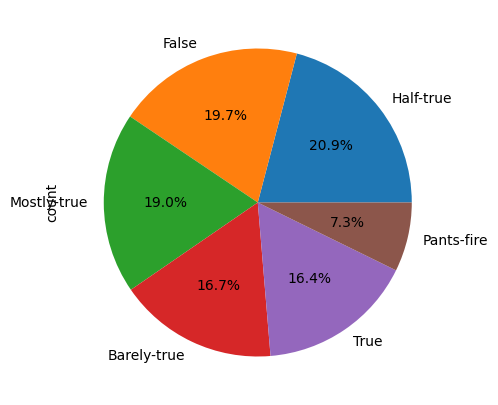

In [6]:
#Data Import and Mangling

#LIAR
liar_df = import_liar()
df_stats("LIAR", liar_df) #balanced



### 1.1.2 - ISOT Benchmark Dataset

ISOT Size(44898, 5)
is_fake
True     23481
False    21417
Name: count, dtype: int64


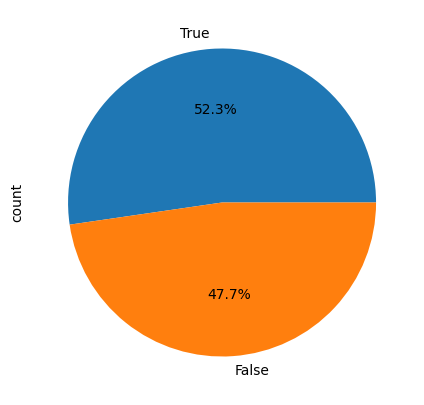

In [7]:

#ISOT
isot_df = import_isot()
df_stats("ISOT", isot_df) #balanced


### 1.1.3 - FakeNewsNet Benchmark Dataset

FakeNewsNet Size(23196, 5)
is_fake
False    17441
True      5755
Name: count, dtype: int64


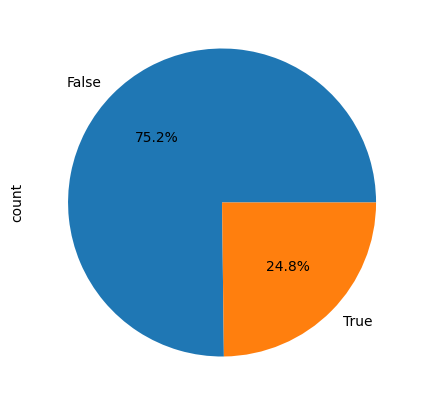

In [8]:

#FakeNewsNet
fnn_df = import_fnn()
df_stats("FakeNewsNet", fnn_df) #unbalanced data set


### 1.1.4 - Fakeddit Benchmark Dataset

Fakeddit Size(84654, 21)
is_fake
False    42344
True     42310
Name: count, dtype: int64


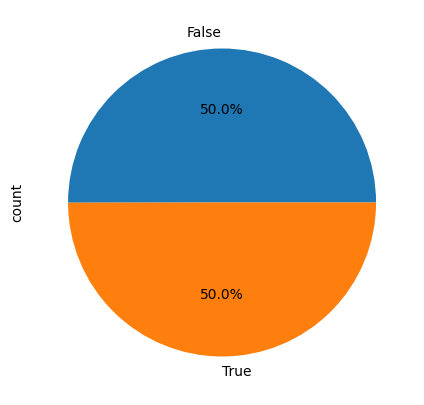

In [9]:

#FAKEDDIT
fe_df = import_fe()
df_stats("Fakeddit", fe_df, False) #balanced


### 1.2 - Pre-processing

In [11]:
# Preprocessing 

def clean_text(s):
    #Lowercase, remove html, strip non-alphanumeric, remove spaces, remove stop words, lemmatize

    #if s is NaN then exit
    # if not s==s: 
    #     return s
    
    #1 - lowercase
    s = s.lower() 

    #2 - remove html using basic regex.  
    dehtml = re.compile(r'<[^>]*>')
    s= dehtml.sub('', s)

    #3 - Strip non alphanumeric away to spaces
    s = re.sub (r'[^a-z0-9\s]',' ',s) 
    
    #4 - Remove excess spaces
    s = re.sub (r'\s+',' ', s).strip() 

    #5 - remove stop words from the sentence 
    tokens=  s.split()
    stop_words = set(stopwords.words('english'))
    filtered = [token for token in tokens if token not in stop_words]
    s = " ".join(filtered)

    #6 - lemmatize and remove from sentence
    tokens = s.split()
    lemmatizer = WordNetLemmatizer()
    filtered = [lemmatizer.lemmatize(token) for token in tokens]
    s = " ".join (filtered)

    return s





#Clean a passed in dataframe desc column -> clean_text
def clean_df (df):
    #copy the df
    clean = df.copy()
    #add our processed column with tqdm goodness for progress
    clean['clean_description'] = clean['description'].progress_apply (clean_text)
    #reset the df
    clean.reset_index(inplace=True, drop=True)
    #Move clean_description to before is_true for ease of visibility
    clean.insert(len(df.columns)-1, 'clean_description', clean.pop('clean_description'))
    display(clean.head())
    return clean



#### Test cleaning

In [12]:
sentence = (clean_text('This IS a Lawrence\'s of Arabia\'s <B>rather</B> #Brilliant \t  <i>set</i> of  lots of SentEnces...'))
print (sentence)

lawrence arabia rather brilliant set lot sentence


#### Clean all data sets

In [13]:
liar_df = clean_df(liar_df)

isot_df = clean_df(isot_df)

fnn_df = clean_df(fnn_df)

fe_df = clean_df(fe_df)

print ("Processed")

  0%|          | 0/1267 [00:00<?, ?it/s]

,0,1,3,4,5,6,7,8,9,10,11,12,13,description,clean_description,is_fake
0,11972.json,true,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,Building a wall on the U.S.-Mexico border will...,building wall u mexico border take literally year,True
1,11685.json,false,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,Wisconsin is on pace to double the number of l...,wisconsin pace double number layoff year,False
2,11096.json,false,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,Says John McCain has done nothing to help the ...,say john mccain done nothing help vet,False
3,5209.json,half-true,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici support plan cut choice medic...,Half-true
4,9524.json,pants-fire,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,When asked by a reporter whether hes at the ce...,asked reporter whether he center criminal sche...,Pants-fire


  0%|          | 0/44898 [00:00<?, ?it/s]

,title,subject,date,description,clean_description,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters) - The head of a conservat...,washington reuters head conservative republica...,False
1,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters) - Transgender people will...,washington reuters transgender people allowed ...,False
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters) - The special counsel inv...,washington reuters special counsel investigati...,False
3,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters) - Trump campaign adviser ...,washington reuters trump campaign adviser geor...,False
4,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters) - President Donal...,seattle washington reuters president donald tr...,False


  0%|          | 0/23196 [00:00<?, ?it/s]

,id,news_url,tweet_ids,description,clean_description,is_fake
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,284329075902926848\t284332744559968256\t284335...,Did Miley Cyrus and Liam Hemsworth secretly ge...,miley cyrus liam hemsworth secretly get married,True
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,992895508267130880\t992897935418503169\t992899...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,paris jackson cara delevingne enjoy night matc...,True
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,853359353532829696\t853359576543920128\t853359...,Celebrities Join Tax March in Protest of Donal...,celebrity join tax march protest donald trump,True
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,988821905196158981\t988824206556172288\t988825...,Cindy Crawford's daughter Kaia Gerber wears a ...,cindy crawford daughter kaia gerber wear wig d...,True
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,955792793632432131\t955795063925301249\t955798...,Full List of 2018 Oscar Nominations – Variety,full list 2018 oscar nomination variety,True


  0%|          | 0/84654 [00:00<?, ?it/s]

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,clean_title,created_utc,domain,hasImage,id,...,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,description,clean_description,is_fake
0,0,0,NaN,NaN,buzzly6,virginia first lady criticized for handing cot...,1.551316e+09,philly.com,False,avkxum,...,2.0,16,nottheonion,0.69,1,0,0,Virginia first lady criticized for handing cot...,virginia first lady criticized handing cotton ...,False
1,1,1,NaN,NaN,NaN,jason falconer reluctant hero stopped mall att...,1.474326e+09,cnn.it,False,53kdz3,...,0.0,7,upliftingnews,0.77,1,0,0,Jason Falconer: Reluctant hero stopped mall at...,jason falconer reluctant hero stopped mall att...,False
2,3,3,NaN,NaN,NaN,woman bites camels testicles to save herself a...,1.569178e+09,wbrz.com,False,d7upss,...,3.0,7,nottheonion,1.00,1,0,0,Woman bites camel’s testicles to save herself ...,woman bite camel testicle save freak encounter,False
3,4,4,190207.0,862707.0,trustbytrust,stargazer,1.425139e+09,NaN,True,cozywbv,...,NaN,3,psbattle_artwork,NaN,0,2,4,stargazer,stargazer,True
4,5,5,NaN,NaN,confession_SS,driving scares me a few little kittens down a ...,1.562530e+09,self.SubredditSimulator,False,cab6hd,...,19.0,2,subredditsimulator,0.76,0,2,3,Driving scares me a few little kittens down a ...,driving scare little kitten couple month sobri...,True


Processed


#### Create Combined Dataset

Combined Size(154015, 3)
is_fake
False          81202
True           71546
Half-true        265
False            249
Mostly-true      241
Barely-true      212
True             208
Pants-fire        92
Name: count, dtype: int64


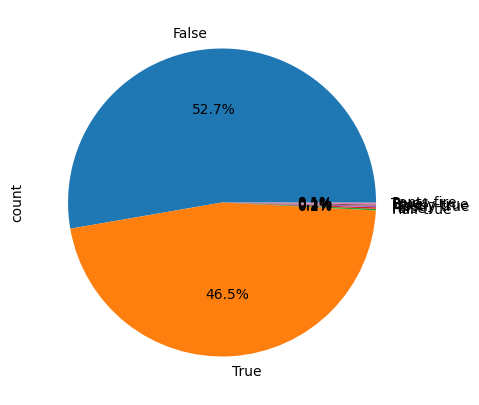

In [14]:

collated = [liar_df[['description', 'clean_description', 'is_fake']], 
            isot_df[['description', 'clean_description', 'is_fake']],
            fnn_df[['description', 'clean_description', 'is_fake']],
            fe_df[['description', 'clean_description', 'is_fake']],
            ]
combined_df = pd.concat(collated)

df_stats ("Combined",combined_df)

### 1.3 - Feature Extraction

#### Testing Flair

In [15]:
from flair.data import Sentence
from flair.models import SequenceTagger

sentence = (clean_text('This IS a Lawrence\'s of Arabia\'s <B>rather</B> #Brilliant \t  <i>set</i> of  lots of SentEnces...'))
print (sentence)
# create a sentence
sentence = Sentence(sentence)
# load the NER tagger
tagger = SequenceTagger.load('ner')

# predict the named entities in the sentence
tagger.predict(sentence)

# print the predicted named entities
for entity in sentence.get_spans('ner'):
    print(entity)

#can see named entity is listed for lawrence (of) arabia -> person 

lawrence arabia rather brilliant set lot sentence
2024-01-08 11:08:59,282 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Span[0:2]: "lawrence arabia" → PER (0.9447)


#### Prototype Testing 

In [16]:
#Prototype uses a single test classifier and feature extractor  
classifiers=dict()
classifiers['dt'] = DecisionTreeClassifier()

extractors=dict()
extractors['tfidf'] = TfidfVectorizer(stop_words='english', max_df=0.7)

### 1.4 - Training

In [17]:

def evaluate (y_true, y_predicted):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_predicted) 
    sns.heatmap(cm, annot=True, cmap='rocket_r', fmt= '.5g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    # F1 Scoring and Accuracy
    print('') 
    display('Accuracy, Precision, Recall and F1-score')
    print(classification_report(y_true, y_predicted, digits=5))


def train (name, x_train, x_test, y_train, y_test):
    #name datasource name
    #x_train, x_test use the extractors to train
    #y_train, y_test use the classifiers to train

    transformed_train=extractors['tfidf'].fit_transform(x_train)
    transformed_test=extractors['tfidf'].transform(x_test)

    classifiers['dt'].fit (transformed_train, y_train)
    y_pred = classifiers['dt'].predict(transformed_test)

    print (name)
    evaluate (y_test,y_pred)



    

### 1.5 - Classification (Prediction Scoring)
#### Single example shown for video for speed reasons

  0%|          | 0/1 [00:00<?, ?it/s]

ISOT


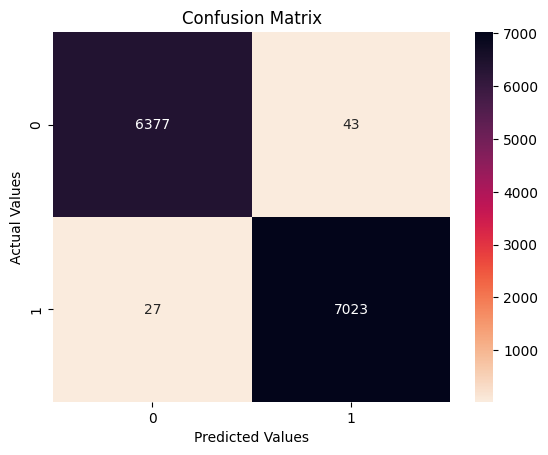

'Accuracy, Precision, Recall and F1-score'

              precision    recall  f1-score   support

       False    0.99578   0.99330   0.99454      6420
        True    0.99391   0.99617   0.99504      7050

    accuracy                        0.99480     13470
   macro avg    0.99485   0.99474   0.99479     13470
weighted avg    0.99481   0.99480   0.99480     13470



In [18]:

#isot_df
#liar_df
#fnn_df
#fe_df
#combined_df

training = dict()

training['ISOT'] = isot_df #too slow to show more than one training sample in video
#training['LIAR'] = liar_df
#training['FNN'] = fnn_df
#training['FEDDIT'] = fe_df
#training['COMBINED']= combined_df
 

for name, df in tqdm(training.items()):
    labels = df.is_fake
    x_train, x_test, y_train, y_test=train_test_split(isot_df['clean_description'], labels, test_size=0.3, random_state=7)

    train ( name,x_train, x_test, y_train, y_test)

    

## Analysis

In [ ]:
# To be added at a later stage